In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading cleaned data
df = pd.read_csv('merged_wpv_cleaned.csv')

# Display basic data information
print(df.head())
print(df.info())
print(df.describe(include='all'))


            event_date       facility_type  \
0  2024-01-16 00:00:00  Med/Surg/Inpatient   
1  2024-02-06 00:00:00               Other   
2  2024-02-26 00:00:00  Med/Surg/Inpatient   
3  2024-03-29 00:00:00               Other   
4  2024-04-28 00:00:00  Med/Surg/Inpatient   

  occupational_category_of_person_affected  \
0     Physician/Advanced Practice Provider   
1                                    Other   
2                          Nurse (RN, LPN)   
3               Allied Health/Technologist   
4                          Nurse (RN, LPN)   

  department_office_incident_took_place aggressor type_of_violence  \
0                          Patient room   Patient         Physical   
1                               Hallway   Patient           Verbal   
2                          Patient room   Patient           Verbal   
3                               Hallway   Patient         Physical   
4                               Hallway   Patient         Physical   

  primary_assault_descrip

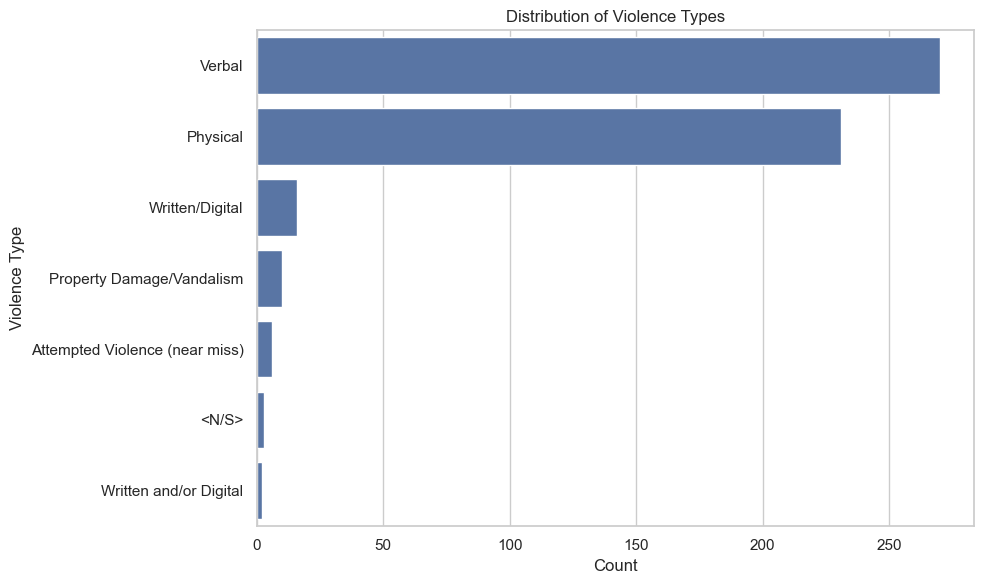

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set drawing style
sns.set(style="whitegrid")

# Mapping the distribution of types of violence
plt.figure(figsize=(10, 6))
sns.countplot(y='type_of_violence', 
              data=df, 
              order=df['type_of_violence'].value_counts().index)
plt.title('Distribution of Violence Types')
plt.xlabel('Count')
plt.ylabel('Violence Type')
plt.tight_layout()
plt.show()


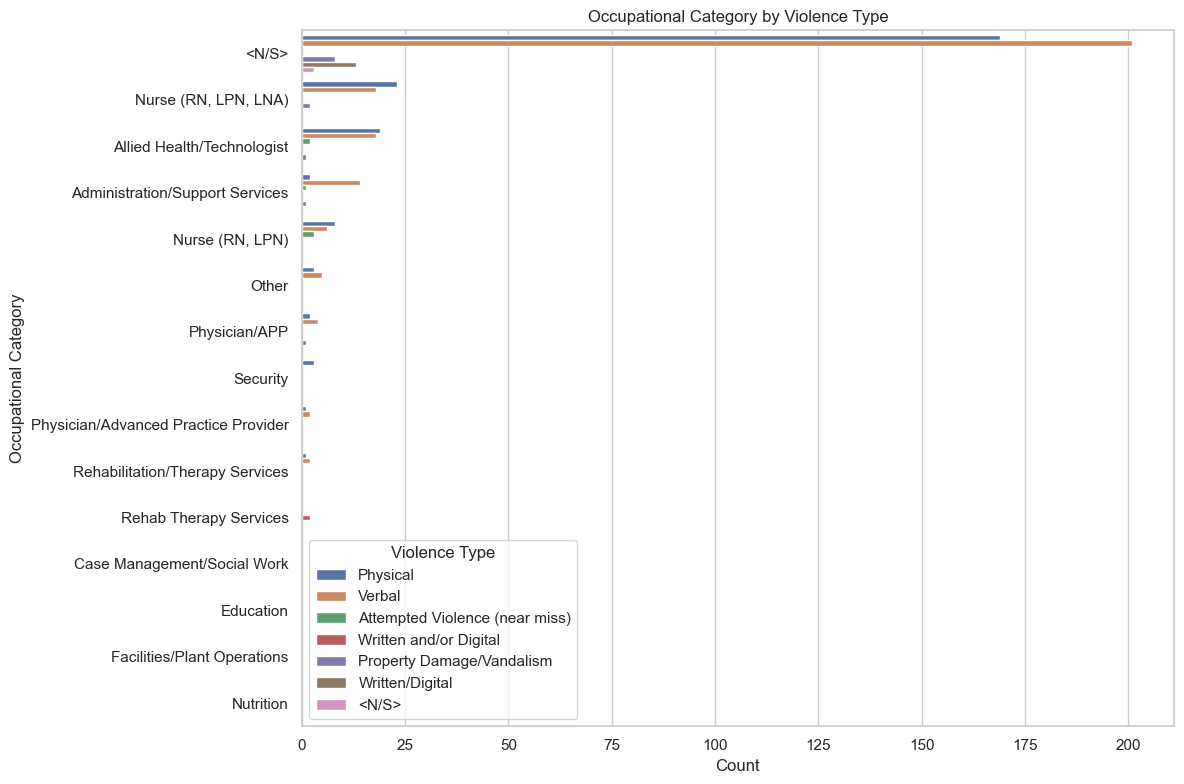

In [3]:
# Cross-analysis of occupation and violence type
plt.figure(figsize=(12, 8))
sns.countplot(y='occupational_category_of_person_affected', 
              hue='type_of_violence',
              data=df, 
              order=df['occupational_category_of_person_affected'].value_counts().index)
plt.title('Occupational Category by Violence Type')
plt.xlabel('Count')
plt.ylabel('Occupational Category')
plt.legend(title='Violence Type')
plt.tight_layout()
plt.show()


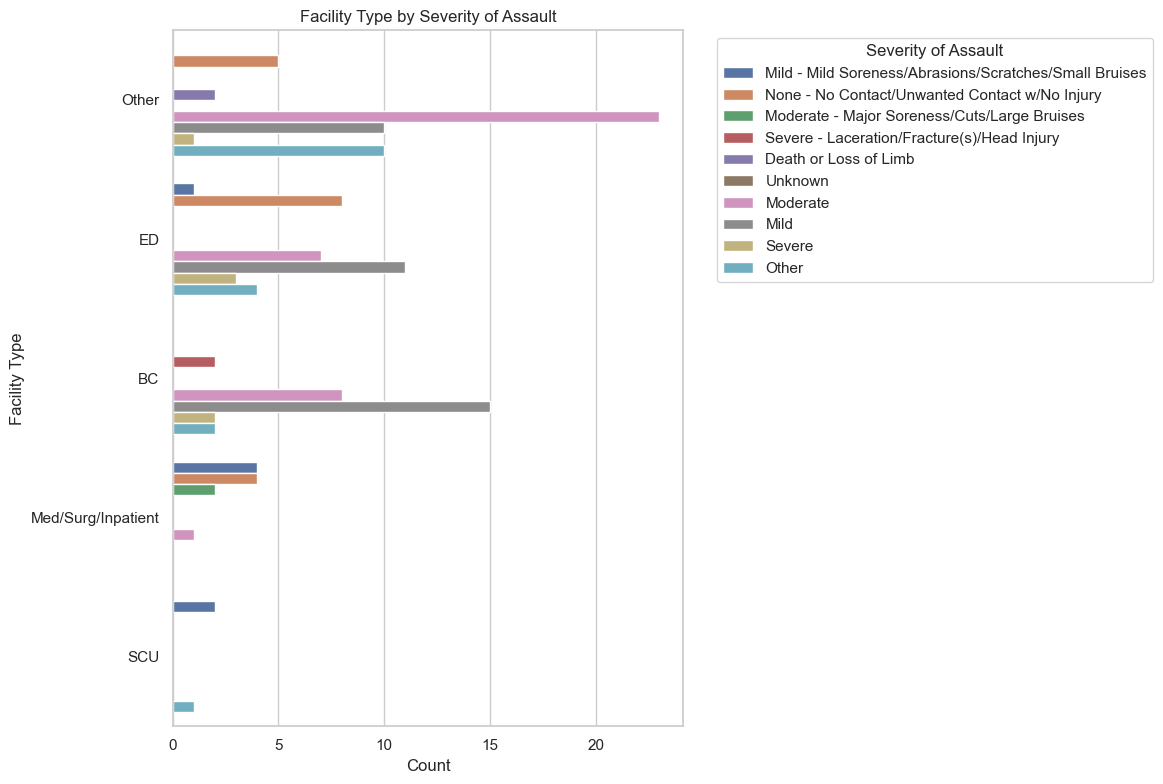

In [4]:
# Analysis of the relationship between severity of violence and type of medical facilities
plt.figure(figsize=(12, 8))
sns.countplot(y='facility_type', 
              hue='severity_of_assault',
              data=df, 
              order=df['facility_type'].value_counts().index)
plt.title('Facility Type by Severity of Assault')
plt.xlabel('Count')
plt.ylabel('Facility Type')
plt.legend(title='Severity of Assault', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Select the required features and target variables
features = ['facility_type', 
            'occupational_category_of_person_affected',
            'department_office_incident_took_place', 
            'aggressor', 
            'type_of_violence']

target = 'severity_of_assault'

# Data subset
df_subset = df[features + [target]].copy()

# Remove missing or unknown severity data
df_subset = df_subset[df_subset[target].notnull() & (df_subset[target] != 'Unknown')]

# Encode target variable
label_encoder = LabelEncoder()
df_subset['severity_encoded'] = label_encoder.fit_transform(df_subset[target])

# One-hot encoding feature variables
df_features_encoded = pd.get_dummies(df_subset[features])

# Divide the dataset
X_train, X_test, y_train, y_test = train_test_split(
    df_features_encoded, 
    df_subset['severity_encoded'], 
    test_size=0.25, 
    random_state=42
)

# Display data dimensions
print(X_train.shape, X_test.shape)


(96, 33) (32, 33)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Random Forest Model Training
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Logistic regression model training
logreg_model = LogisticRegression(max_iter=500, random_state=42)
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)

# Model evaluation
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf, 
                            labels=np.unique(y_pred_rf),
                            target_names=label_encoder.classes_[np.unique(y_pred_rf)]))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred_logreg, 
                            labels=np.unique(y_pred_logreg),
                            target_names=label_encoder.classes_[np.unique(y_pred_logreg)]))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))



Random Forest Classifier Results:
                                                        precision    recall  f1-score   support

                                                  Mild       0.43      0.67      0.52         9
Mild - Mild Soreness/Abrasions/Scratches/Small Bruises       1.00      0.25      0.40         4
                                              Moderate       0.80      0.31      0.44        13
          Moderate - Major Soreness/Cuts/Large Bruises       1.00      1.00      1.00         1
        None - No Contact/Unwanted Contact w/No Injury       0.57      1.00      0.73         4
                                                 Other       0.00      0.00      0.00         1

                                              accuracy                           0.50        32
                                             macro avg       0.63      0.54      0.52        32
                                          weighted avg       0.67      0.50      0.50        32

Acc

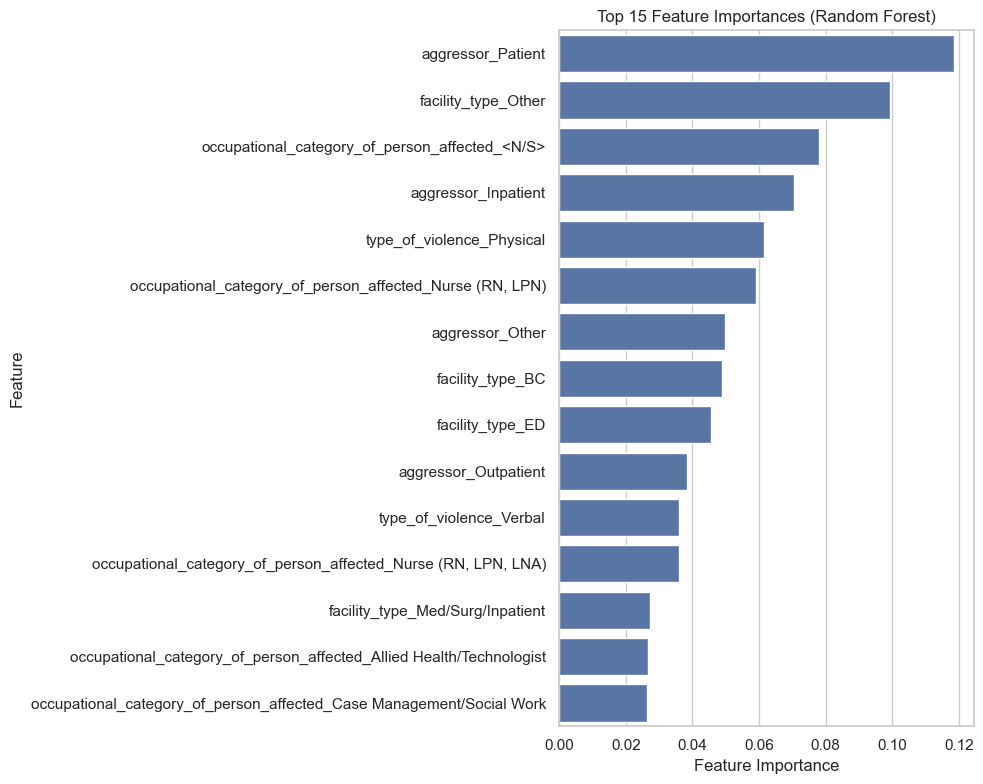

In [7]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(y=X_train.columns[indices][:15], x=importances[indices][:15])
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


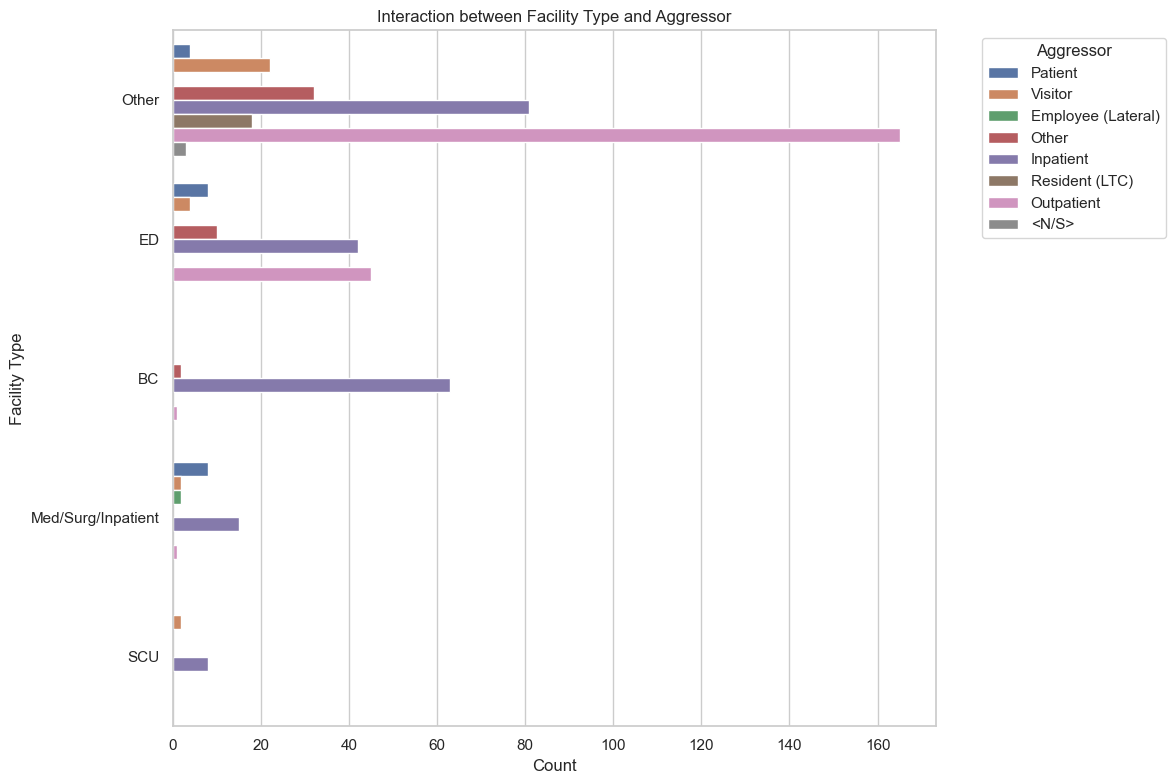

In [8]:
#Interaction Analysis
plt.figure(figsize=(12, 8))
sns.countplot(y='facility_type', hue='aggressor', data=df,
              order=df['facility_type'].value_counts().index)
plt.title('Interaction between Facility Type and Aggressor')
plt.xlabel('Count')
plt.ylabel('Facility Type')
plt.legend(title='Aggressor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [9]:
# PCA Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features_encoded)

pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])


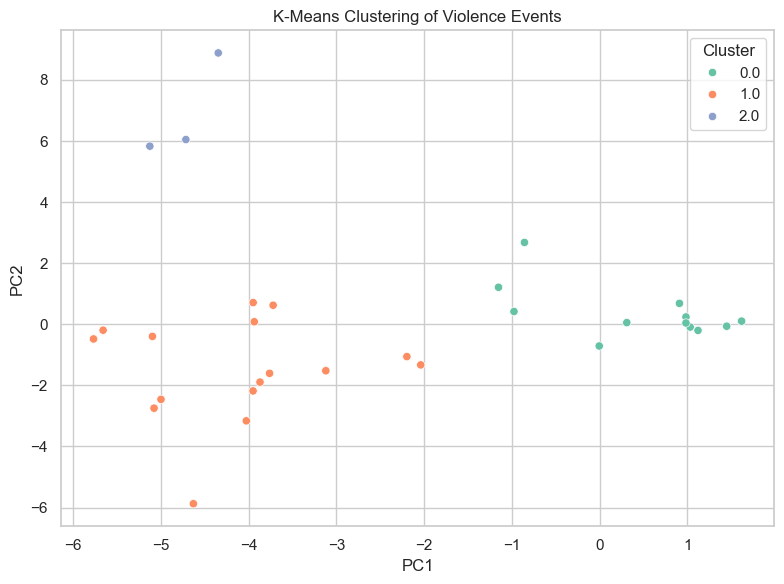

In [10]:
#Clustering Analysis
from sklearn.cluster import KMeans

# Use the data after PCA dimensionality reduction to perform cluster analysis
kmeans = KMeans(n_clusters=3, random_state=42)
df_subset['cluster'] = kmeans.fit_predict(pca_df)

# Display clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=df_subset['cluster'], palette='Set2')
plt.title('K-Means Clustering of Violence Events')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


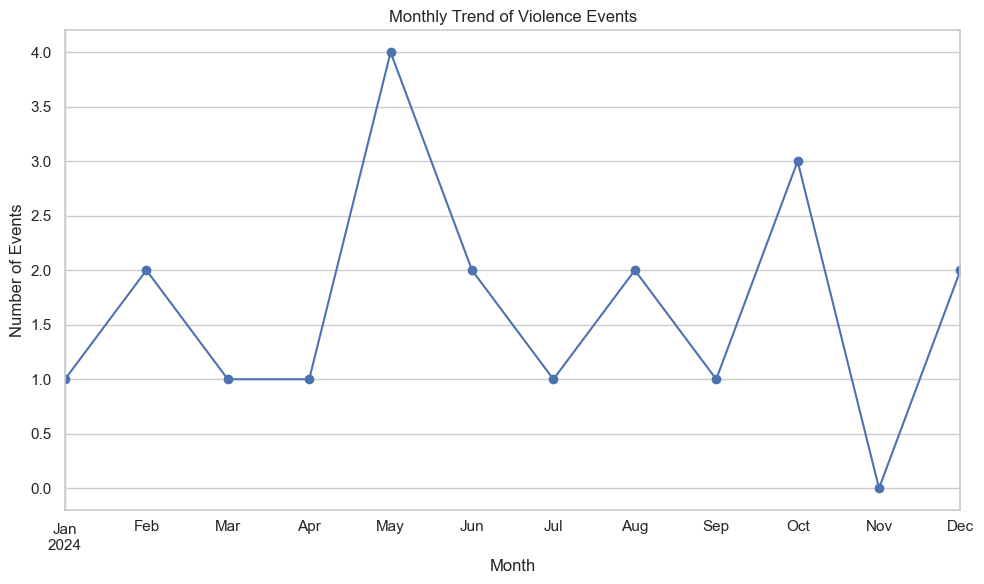

In [11]:
#Time Series Analysis

# Convert date format
df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')

# Delete records with empty date
df_clean_date = df.dropna(subset=['event_date'])

# Statistics of events by month
monthly_events = df_clean_date.set_index('event_date').resample('ME').size()

# Visualization
plt.figure(figsize=(10, 6))
monthly_events.plot(marker='o')
plt.title('Monthly Trend of Violence Events')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.grid(True)
plt.tight_layout()
plt.show()
